# Tabular Reinforcement Learning assignment (18 p)

## Setup instructions

This folder contains a `uv.lock` file which allows you to run `uv sync` (assuming you have [uv](https://docs.astral.sh/uv/) installed) to create a virtual environment at `.venv`. Alternatively, you can create a virtual environment manually and install the correct packages by running `pip install -r requirements.txt`.

Before running code cells in this notebook, ensure that you have selected the correct python kernel, located at `.venv`.

## Introduction
This assignment will give you practice in creating your own reinforcement learning agents in tabular environments.

The assignment will use the [gymnasium](https://gymnasium.farama.org/) structure, 
and I suggest you familiarize yourselves with this before getting started. In particular, the documentation about the
[step](https://gymnasium.farama.org/api/env/#gymnasium.Env.step) method might be useful.

The assignment is split into the following tasks:
1. Understand the code for an MDP environment.
2. Implement MDP simulation logic.
3. Plot results from simulations with a random policy.
4. Answer some theoretical questions about Q-learning, SARSA and ESARSA.
5. Calculate optimal Q-values by using value iteration.
6. Learn optimal Q-values by using Q-learning.

Each task will have a brief description, followed by specific instructions under each subtask.

Feel free to slightly modify the provided code if needed. For example, if your agents don't behave as expected, it might be useful to add logging statements during the simulation. However, deviating *too* much from the provided structure makes it more difficult to grade and is therefore discouraged.

In [2]:
# Imports. You should not have to change anything here, but you are allowed to do so.
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from typing import final, override, Protocol, Callable, TypeVar
from tqdm import tqdm

## Task 1: Interpreting MDPs

Here is the environment that we will solve in this assignment:

In [3]:
@final
class RiverSwim(gym.Env):
    def __init__(self, n_states=6, small=5/1000, large=1, seed: int | None = None):
        self.n_states = n_states
        self.small = small  # payout for 'backwards' action
        self.large = large  # payout at end of chain for 'forwards' action
        self.state = 0  # Start at beginning of the chain
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(self.n_states)


    @override
    def step(self, action):
        assert self.action_space.contains(action)


        reward = 0

        if action == 0:  # Go left
            if self.state == 0:
                reward = self.small
            else:
                self.state -= 1
        else: # Go right
            if self.state == 0:
                self.state = int(self.np_random.choice([self.state, self.state + 1], p=[0.4, 0.6]))
            elif self.state < self.n_states - 1:
                self.state = int(self.np_random.choice([self.state-1, self.state, self.state + 1], p=[0.05, 0.6, 0.35]))
            else: # self.state == self.n_states - 1
                self.state = int(self.np_random.choice([self.state-1, self.state, 0], p=[0.4, 0.4, 0.2]))
                if self.state == 0:
                    reward = self.large

        terminated = False
        truncated = False
        info = {}
        return self.state, reward, terminated, truncated, info


    @override
    def reset(self, seed: int | None = None, options: dict | None = None):
        super().reset(seed=seed)
        self.state = 0
        info = {}
        return self.state, info

To check your understanding of this MDP, you should now draw a model of it. You can use any tool you like, e.g. pen and paper, draw.io, etc. Please make it readable.

For each transition, annotate the transition probability and reward. If the reward is zero, you can leave it out.

Here is an example for a different environment:

![](images/MDP-example.png)

Remember to double check that your transition probabilities (for a fixed action) sum to $1$.

### Task 3.1 (2 p)
Draw the MDP diagram of the `RiverSwim` environment when `n_states=4`.

#### Answer

Reward written in parenthesis, probabilities written outright.

![](images/3.1.jpg)

### Task 3.2 (0.5 p)
Is this an episodic or continuing environment?

#### Answer

It is a continuing environment since there is no set goal for termination and no truncation bounds, the algorithm may continue forever.

## Task 2: MDP simulation logic

Once the environment is defined, we can move on to interacting with it. Before we bother with acting *optimally*, let us first ensure that we can act randomly.

The MDP simulation code must assume an interface for acquiring actions from the agent, and for training the agent. For this we will use the very simple `RiverSwimAgent` protocol below. You will first create a purely random agent that implements this, and later on a smarter agent as well.

`RiverSwimAgentT` is defined as a type variable bound to `RiverSwimAgent`. You do not have to understand this fully and it is merely included for type annotation purposes. Only remember that whenever you read `RiverSwimAgentT` you should interpret it as "any agent that implements the `RiverSwimAgent` protocol".

In [4]:
class RiverSwimAgent(Protocol):
    """An agent for the RiverSwim environment. Observations and actions are always integers."""


    def act(self, observation: int) -> int:
        """Given an observation, return an action."""
        ...

    def update(self, observation: int, action: int, reward: float, next_observation: int) -> None:
        """Update the agent's internal state given a (S,A,R,S) transition."""
        ...

RiverSwimAgentT = TypeVar("RiverSwimAgentT", bound=RiverSwimAgent)

Some scaffolding has been provided but you have to implement the core logic yourself.

### Task 2.1 (2 p)
Implement the `riverswim_simulation` function. Make sure that you use all the parameters of the function. Notably, `callback` will later allow us to visualize an agent's training progress.

#### Answer

In [5]:
def riverswim_simulation(
        env: RiverSwim,
        agent: RiverSwimAgentT,
        n_steps: int,
        # Callback takes (agent, state, action, reward) as input
        # Useful for visualizing agent properties during training
        callback: Callable[[RiverSwimAgentT, int, int, float], None],
        callback_interval: int # in number of steps, how often to call the callback
    ) -> tuple[list[int], list[int], list[float]]:
    """Train `agent` in `env` for `n_steps` steps.

    Args:
        env: The RiverSwim environment.
        agent: The agent to train.
        n_steps: Number of steps to train for.
        callback: A function to call every `callback_interval` steps. Will be called with (agent, state, action, reward).
        callback_interval: How often to call the callback.

    Return lists of states, actions and rewards."""
    states, actions, rewards = [], [], []

    state, _ = env.reset()
    states.append(state)

    for step in range(n_steps):
        action = agent.act(state)
        next_state, reward, _, _, _ = env.step(action)
        agent.update(state, action, reward, next_state)

        actions.append(action)
        rewards.append(reward)
        states.append(next_state)

        if callback_interval > 0 and (step + 1) % callback_interval == 0:
            callback(agent, state, action, reward)

        state = next_state


    # States should contain S_0, S_1, ..., S_n_steps
    # Actions should contain A_0, A_1, ..., A_{n_steps-1}
    # Rewards should contain R_1, R_2, ..., R_{n_steps}
    assert len(states) == n_steps + 1
    assert len(actions) == n_steps
    assert len(rewards) == n_steps

    return states, actions, rewards

### Task 2.2 (0.5 p)
Implement the `RandomRiverSwimAgent` class.

#### Answer

In [6]:
class RandomRiverSwimAgent(RiverSwimAgent):
    def __init__(self, seed: int | None = None):
        self.rng = np.random.default_rng(seed)

    # TODO
    def act(self, observation: int) -> int:
        return self.rng.integers(2)
    
    def update(self, observation: int, action: int, reward: float, next_observation: int) -> None:
        pass

## Task 3: Gathering data and plotting

Now that we have an environment, an agent (albeit a very trivial one), and modelled the interaction between them, let's start gathering some data.

Since RL is stochastic by nature, it is not enough to train an agent a single time if we want a reliable measure of the algorithm's performance. We have to do it multiple times so we can calculate both the average performance and variance.

You are given this function which uses the `riverswim_simulation` function to train an agent multiple times. It returns numpy arrays of states, actions and rewards. Note that it only uses the callback during the final training run.

In [7]:
def multiple_training_runs(
        env_factory: Callable[[], RiverSwim],
        agent_factory: Callable[[], RiverSwimAgentT],
        n_steps: int,
        n_runs: int,
        callback: Callable[[RiverSwimAgentT, int, int, float], None],
        callback_interval: int
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray, RiverSwimAgentT]:
    """Train an agent multiple times in the RiverSwim environment.

    Args:
        env_factory: A function that creates a new RiverSwim environment.
        agent_factory: A function that creates a new RiverSwimAgent.
        n_steps: Number of steps to train each agent for.
        n_runs: Number of training runs to perform.
        callback: A function to forward to `riverswim_calculation` during the final training run.
        callback_interval: Forward to `riverswim_calculation`, only relevant for the final training run.
    Returns:
        all_states: Array of shape (n_runs, n_steps + 1) containing states
        all_actions: Array of shape (n_runs, n_steps) containing actions
        all_rewards: Array of shape (n_runs, n_steps) containing rewards
        final_agent: The agent from the final training run
    """
    all_states = np.zeros((n_runs, n_steps + 1), dtype=int)
    all_actions = np.zeros((n_runs, n_steps), dtype=int)
    all_rewards = np.zeros((n_runs, n_steps), dtype=float)

    env = env_factory()
    agent: RiverSwimAgentT | None = None

    for run in tqdm(range(n_runs), desc="Training runs"):
        agent = agent_factory()
        if run == n_runs - 1:
            states, actions, rewards = riverswim_simulation(env, agent, n_steps, callback, callback_interval)
        else:
            # For all but the last run, we do not need the callback
            states, actions, rewards = riverswim_simulation(env, agent, n_steps, lambda agent,state,action,reward: None, n_steps + 1)
        all_states[run] = states
        all_actions[run] = actions
        all_rewards[run] = rewards

    assert  agent is not None

    return all_states, all_actions, all_rewards, agent

### Task 3.1 (0.5 p)
"Train" the `RandomRiverSwimAgent` on the `RiverSwim` environment (`n_states=6`) 10 times for 100k steps by using the `multiple_training_runs` function. Since the agent does not learn anything, do not provide a callback.

#### Answer

In [8]:
env_factory = lambda: RiverSwim()
agent_factory = lambda: RandomRiverSwimAgent()
n_steps = 10**5
n_runs = 10
callback_interval = 0

all_states, all_actions, all_rewards, agent = multiple_training_runs(env_factory, agent_factory, n_steps, n_runs, None, callback_interval)

Training runs: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


### Task 3.2 (1 p)
Implement `smooth_and_statistics` for smoothing an array along the time dimension and then calculating the mean and standard deviation across the run dimension.

#### Answer

In [9]:
def smooth_and_statistics(array: np.ndarray, window: int) -> tuple[np.ndarray, np.ndarray]:
    """Apply moving average and calculate mean and std across runs.

    Args:
        array: Array of shape (n_runs, n_steps) containing data.
        window: Window size for moving average.
    Returns:
        mean: Mean across runs after smoothing, shape (n_steps-window+1,)
        std: Standard deviation across runs after smoothing, shape (n_steps-window+1,)
    """
    # TODO
    smoothed_runs = np.array([
        np.convolve(run, np.ones(window)/window, mode='valid') 
        for run in array
    ])

    # Step 2: Compute mean across runs (axis=0)
    mean = np.mean(smoothed_runs, axis=0)

    # Step 3: Compute standard deviation across runs (axis=0)
    std = np.std(smoothed_runs, axis=0)

    return mean, std

### Task 3.3 (1.5 p)
Use a window size of 1k and call `smooth_and_statistics` on the rewards acquired by the random agent. Plot the mean (using `plot`) and standard deviation (using `fill_between`) of reward in a figure.

Also state whether the results are reasonable to you or not. Is the reward scale what you expected from a random agent? Why?

#### Answer

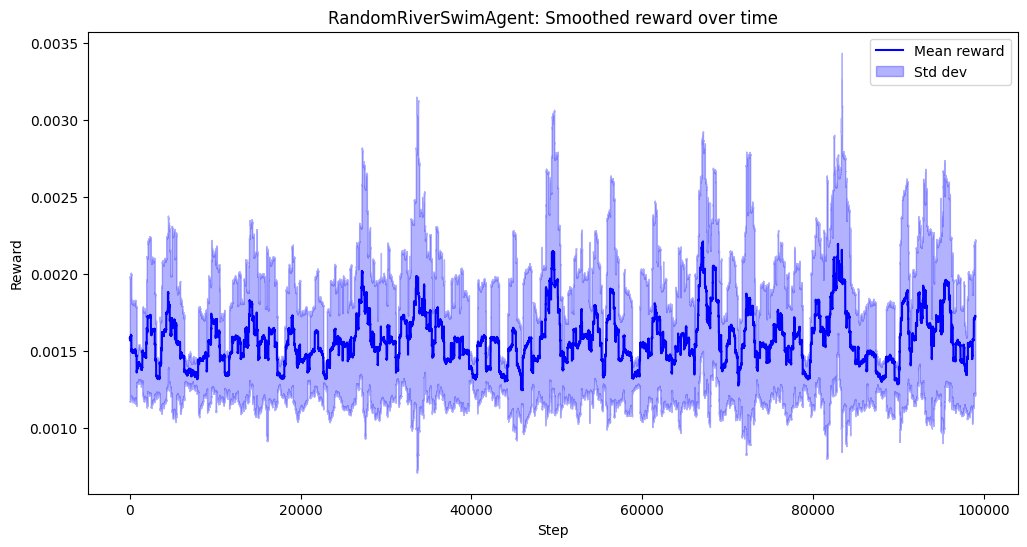

In [10]:
import matplotlib.pyplot as plt

window = 1000

mean_rewards, std_rewards = smooth_and_statistics(all_rewards, window)

plt.figure(figsize=(12, 6))
plt.plot(mean_rewards, label='Mean reward', color='blue')
plt.fill_between(
    range(len(mean_rewards)),
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    color='blue',
    alpha=0.3,
    label='Std dev'
)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('RandomRiverSwimAgent: Smoothed reward over time')
plt.legend()
plt.show()

Since the random policy is likely to get the small reward 0.005 with a considerable probability, but also 0 more often than not, it makes sense that the reward is between 0 and 0.005.

## Task 4: Method background

Now that we know that our simulation works, we are of course interested in solving it, which is the domain of RL. Most tabular RL methods are *value*-based, meaning that they are based on estimations of the expected return, either for states or state-action pairs. Two of the most well-known methods are Q-learning and SARSA.


### Task 4.1 (0.5 p)
Write down the update equation for Q-learning and SARSA. Let $\alpha$ denote the update step size.

#### Answer

**One-step Q-learning update:**

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \Big[ R_{t+1} + \gamma \max_{a'} Q(S_{t+1}, a) - Q(S_t, A_t) \Big]  (4.1.1)
$$ 

**SARSA update:**

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \Big[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \Big] (4.1.2)
$$



### Task 4.2 (0.5 p)
For each algorithm, draw the backup diagram.

#### Answer

TODO

### Task 4.3 (0.25 p)
For each algorithm, state whether $q_\pi$ (action value for the behavior policy) or $q_*$ (action value for the optimal policy) is estimated.

#### Answer

**Q-learning**

$q_*$ is estimated due to being off-policy and updates wuth the meximum possible future action value as shown in (4.1.1).

**SARSA**

$q_\pi$ is estimated due to being on-policy and updates with the action actually taken by the agent.

### Task 4.4 (0.25 p)
For each algorithm, state whether it can be used off-policy or has to be on-policy.

#### Answer

**Q-learning:** Off-policy 

It learns the value of the optimal policy regardless of the actions actually taken by the agent during exploration.  

**SARSA:** On-policy  

It learns the value of the policy that the agent is actually following, including any exploration (e.g., ε-greedy).  


### Task 4.5 (1 p)

Give an example of when each method would be preferable over the other.

#### Answer

**Q-learning:**  
- Off-policy.  
- Estimates $q_*$ (optimal action-value).  
- Better when exploration is safe and you want the true optimal policy.  
- Example: A virtual robot exploring a maze to find the shortest path.  

**SARSA:**  
- On-policy.  
- Estimates $q_\pi$ (action-value of the current policy).  
- Better when exploration is risky and you want to learn the performance of the policy actually followed.  
- Example: A self-driving car learning while occasionally exploring.


## Task 5: Value iteration

For the `RiverSwim` environment, we will use Q-learning as a way of learning a good policy.

However, since we know the exact dynamics of this environment, it can be helpful to calculate the true optimal Q-values *before* we start training our agent. This way, we will immediately see whether our agent works or not.

*Value iteration* is a way of calculating optimal values (either state or state-action) from knowledge about an environments transition dynamics.



### Task 5.1 (0.5 p)
Write down the update equation for *action value iteration*. The LHS should be $q_{k+1}(s,a)$ and the RHS should be a function of
- $p(s',r|s,a)$: The probability of reaching state $s'$ and obtaining reward $r$ given that we choose action $a$ in state $s$.
- $r$: The reward.
- $\gamma$: The discount factor.
- $q_k(s',a')$: The previous Q-value estimate.

#### Answer

$$
q_{k+1}(s, a) = \sum_{s',r}p(s', r | s, a)[r+\gamma\max_{a'} q_k(s',a')]
$$

### Task 5.2 (1.5 p)
Implement `qvalue_iteration`.

#### Answer

In [11]:
def qvalue_iteration(env_dynamics: dict, gamma: float, threshold: float = 1e-6) -> np.ndarray:
    """Perform Q-value iteration given transition probabilities and rewards.

    Args:
        env_dynamics (dict): A dictionary containing environment dynamics. It has the form
            {
                state: {
                    action: [(next_state, reward, probability), ...],
                    ...
                },
                ...
            }
        Note that for a given (state, action) pair, the sum of probabilities of all possible next states should be 1.
        gamma (float): The discount factor.
        threshold (float): A small threshold for determining convergence.

    Returns:
        np.ndarray: A 2D array of shape (n_states, n_actions) representing the optimal Q-values.
    """
    # TODO
    n_states = len(env_dynamics)
    n_actions = len(next(iter(env_dynamics.values())))

    q = np.zeros(n_states, n_actions)

    while True:
        q_new = np.zeros(n_states, n_actions)

        for s, actions in env_dynamics.items():
            for a, transitions in actions.items():
                value = 0.0
                for (s_next, r, prob) in transitions:
                    value += prob * (r + gamma*np.max(q[s_next]))
                q_new[s, a] = value

        diff = np.abs(q_new - q).max()
        q = q_new

        if diff < threshold:
            break
    
    return q


### Task 5.3 (1 p)
- Define a `env_dynamics` dictionary according to the `RiverSwim` environment.
- Calculate the optimal Q-values when $\gamma=0.99$
- Visualize them in a 2x6 image. The exact Q-values should be annotated as text within each pixel. Since we will also want to visualize the Q-values during Q-learning, it is recommended that you create a separate function for this.

One helpful way of understanding the format of `env_dynamics` is
- Start at some state (a large circle in the MDP diagram). This is the first index.
- Choose one of the actions (represented by small black dots in the MDP diagram). This is the second index.
- Each tuple $(s',r,p)$ corresponds directly to one of the arrows that originates from this state-action pair.

As a sanity check, all optimal Q-values are between $3$ and $5$.

#### Answer

In [13]:
env_dynamics = {}

r_small = 5/1000
r_large = 1

# TODO
n_states = 6
for s in range(n_states):
    env_dynamics[s] = {}

    if s == 0:
        env_dynamics[s][0] = [(0, r_small, 1)]
    else:
        env_dynamics[s][0] = [(s - 1, 0, 1)]
    
    if s == 0:
        env_dynamics[s][1] = [(0, 0, 0.4), (1, 0, 0.6)]
    elif s < n_states - 1:
        env_dynamics[s][1] = [
            (s - 1, 0, 0.05),
            (s, 0, 0.6),
            (s + 1, 0, 0.35)
        ]
    else:
        env_dynamics[s][1] = [
            (s - 1, 0, 0.4),
            (s, 0, 0.4),
            (0, r_large, 0.2)
        ]

## Task 6: Q-learning

Let us now train the Q-learning agent.

### Task 6.1 (1 p)
Implement `QLearningRiverSwimAgent`

#### Answer

In [ ]:
class QLearningRiverSwimAgent(RiverSwimAgent):
    def __init__(self, n_states: int, gamma: float, eps: float = 0.1, lr: float = 1e-3, init_val: float = 0, seed: int | None = None):
        # TODO

    # TODO

### Task 6.2 (0.5 p)
Train two different `QLearningRiverSwimAgent`s on the `RiverSwim` environment (`n_states=6`) 10 times for 100k steps by using the `multiple_training_runs` function. One of them should initialize the Q-values to 0, and the other to 5, which is larger than the true Q-values. This sort of initialization is called "optimistic".

Furthermore, use $\gamma=0.99$, the same value that we used for value iteration. You are free to choose `eps` and `lr` as you see fit, although it should be the same for both agents. 

Visualize each agent's Q-values every 10k steps for the last training run, using the `callback` and `callback_interval` arguments of `multiple_training_runs`. Also save the MSE value between the agent's Q-values and the true Q-values.

#### Answer

In [ ]:
# TODO

### Task 6.3 (1 p)
- In one figure, plot the smoothed rewards of both Q-learning agents together with the smoothed rewards from the random policy agent. Use a window size of 1k. Just as before, you should plot the mean reward as a line and standard deviations as filled areas.
- In a second figure, plot the Q-value MSE for both agents with log scale for the y-axis.
- In a third figure, plot action histograms for all three agents. Only consider the last 1000 steps, but across all training runs.

At least one of the agents should attain MSE below $0.1$. If not, go back to the previous task and train again.

#### Answer

In [ ]:
# TODO

### Task 6.4 (2 p)
Which of the two Q-learning agents performs the best, and why?

Your answer is expected to be more detailed than "because of X".

#### Answer

TODO